<a href="https://colab.research.google.com/github/tjwei/GAN_Tutorial/blob/master/CGAN_intro_for_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from skimage.io import imshow

from IPython.display import display

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


In [3]:
train_images.dtype, train_images.shape

(dtype('uint8'), (60000, 28, 28))

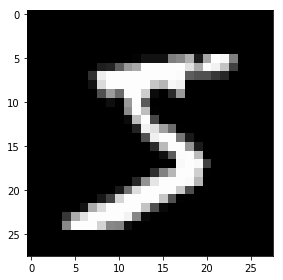

In [4]:
imshow(train_images[0])

In [0]:
def img_to_float(img):
  return (np.float32(img)[..., None]-127.5)/127.5
def img_to_uint8(img):
  return np.uint8(img*127.5+128).clip(0, 255)[...,0]

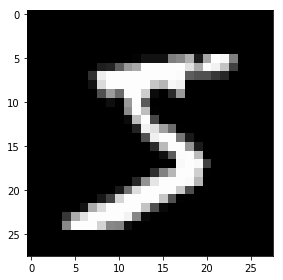

In [6]:
train_img_f32 = img_to_float(train_images)
imshow(img_to_uint8(train_img_f32[0]))

In [0]:
BUFFER_SIZE = train_img_f32.shape[0]
BATCH_SIZE = 32
train_dataset_y = tf.data.Dataset.from_tensor_slices(train_labels).map(lambda y: tf.one_hot(y, 10))
train_dataset_x = tf.data.Dataset.from_tensor_slices(train_img_f32)
train_dataset = tf.data.Dataset.zip((train_dataset_x, train_dataset_y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Input, concatenate
from tensorflow.keras import Model
latent_dim = 100

_0 = Input((latent_dim,))
_1 = Input((10,))
_ = concatenate([_0, _1])
_ = Dense(7*7*256, use_bias=False, input_shape=(latent_dim,))(_)
_ = BatchNormalization()(_)
_ = LeakyReLU()(_)
_ = Reshape((7, 7, 256))(_)
_ = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(_)
_ = BatchNormalization()(_)
_ = LeakyReLU()(_)
_ = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(_)
_ = BatchNormalization()(_)
_ = LeakyReLU()(_)
_ = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(_)
generator = Model(inputs=[_0,_1], outputs=_)

In [0]:
from tensorflow.keras.layers import Conv2D, Dropout, Flatten
_0 = Input((28,28, 1))
_1 = Input((10,))
_ = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(_0)
_ = LeakyReLU()(_)
_ = Dropout(0.3)(_)
_ = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(_)
_ = LeakyReLU()(_)
_ = Dropout(0.3)(_)
_ = Flatten()(_)
_ = concatenate([_, _1])
_ = Dense(50)(_)
_ = BatchNormalization()(_)
_ = LeakyReLU()(_)
_ = Dense(1)(_)
discriminator = Model(inputs=[_0,_1], outputs=_)

In [0]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [0]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [0]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

In [0]:
EPOCHS = 50
num_examples_to_generate = 20

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 latent_dim])
condition_vector_generation = tf.one_hot(list(range(10))+list(range(10)), 10)

In [0]:
def train_step(images, labels):
   # generating noise from a normal distribution
      noise = tf.random_normal([BATCH_SIZE, latent_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)
      
        real_output = discriminator([images, labels], training=True)
        generated_output = discriminator([generated_images, labels], training=True)
         
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

In [30]:
train_step = tf.contrib.eager.defun(train_step)

W0827 10:26:18.462597 140697789507456 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [31]:
for epoch in range(15):
  start_time = time.time()
  for images, labels in train_dataset:
      train_step(images, labels)
  fake = generator([random_vector_for_generation, condition_vector_generation], training=False)
  fake_concat = np.transpose(img_to_uint8(fake), [1,0,2]).reshape((28,-1))
  print(epoch, time.time()-start_time)
  display(PIL.Image.fromarray(fake_concat))
  
  

W0827 10:26:53.281112 140697789507456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/converters/directives.py:117: The name tf.losses.sigmoid_cross_entropy is deprecated. Please use tf.compat.v1.losses.sigmoid_cross_entropy instead.

W0827 10:26:53.317682 140697789507456 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0 23.431277751922607


1 17.45517611503601


2 17.109047889709473


3 16.944669008255005


4 16.957868099212646


5 17.08445143699646


6 17.091964721679688


7 17.022559642791748


8 17.010597944259644


9 17.030638217926025


10 17.03354239463806


11 17.013455867767334


12 17.011053323745728


13 17.027544260025024


14 17.035974264144897
